In [152]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import os
import matplotlib.pyplot as plt
import time
# from PIL import Image

plt.rcParams['figure.figsize'] = (16.0, 16.0)

%matplotlib inline 

# TensorFlow全新的数据读取方式：Dataset API

Data Input Pipeline Performance:
https://www.tensorflow.org/guide/performance/datasets

TensorFlow全新的数据读取方式：Dataset API入门教程:
https://zhuanlan.zhihu.com/p/30751039  

性能优化
http://d0evi1.com/tensorflow/performance/



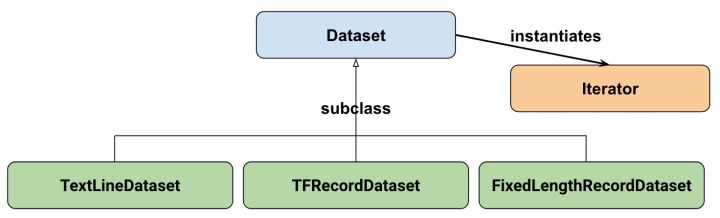

In [17]:
Image(filename=r'D:\wangfeicheng\Tensorflow\tensorflow-learning\images\Dataset_api.jpg')

两个最重要的基础类：
- Dataset  
Dataset可以看作是相同类型“元素”的有序列表。在实际使用时，单个“元素”可以是向量，也可以是字符串、图片，甚至是tuple或者dict。
- Iterator




## Extract: 创建Dataset的方式：
从内存读取创建Dataset的方式：
- tf.data.Dataset.from_tensor_slices(): 

目前Dataset API还提供了另外三种硬盘的读取创建Dataset的方式：
- tf.data.TextLineDataset()：  
  这个函数的输入是一个文件的列表，输出是一个dataset.
  dataset中的每一个元素就对应了文件中的一行。  
  可以使用这个函数来读入CSV文件。
- tf.data.FixedLengthRecordDataset()：  
  这个函数的输入是一个文件的列表和一个record_bytes，之后dataset的每一个元素就是文件中固定字节数record_bytes的内容。  
  通常用来读取以二进制形式保存的文件，如CIFAR10数据集就是这种形式。
- tf.data.TFRecordDataset(file,num_parallel_reads)：  
  这个函数是用来读TFRecord文件的  
  dataset中的每一个元素就是一个TFExample    
  num_parallel_reads: feed data in a parallel thread

## tf.data.Dataset.from_tensor_slices():  从内存读取创建Dataset的方式：


In [20]:
sess = tf.InteractiveSession()

In [33]:
dataset = tf.data.Dataset.from_tensor_slices(np.random.uniform(size = (5,2)))
print(dataset)

<TensorSliceDataset shapes: (2,), types: tf.float64>


In [34]:
iterator = dataset.make_one_shot_iterator()
one_element = iterator.get_next()
for i in range(5):
    print(sess.run(one_element))

[0.19748575 0.88118175]
[0.85730123 0.27503344]
[0.50192365 0.83935051]
[0.58032887 0.63073654]
[0.27947467 0.2827759 ]


tf.data.Dataset.from_tensor_slices():    
切分传入Tensor的第一个维度，生成相应的dataset。最后生成的dataset中一个含有5个元素，每个元素的形状是(2, )，即每个元素是矩阵的一行。  
在实际使用中，我们可能还希望Dataset中的每个元素具有更复杂的形式，如每个元素是一个Python中的元组，或是Python中的词典。例如，在图像识别问题中，一个元素可以是{"image": image_tensor, "label": label_tensor}的形式，这样处理起来更方便。

语句iterator = dataset.make_one_shot_iterator()从dataset中实例化了一个Iterator，这个Iterator是一个“one shot iterator”，即只能从头到尾读取一次。one_element = iterator.get_next()表示从iterator里取出一个元素。由于这是非Eager模式，所以one_element只是一个Tensor，并不是一个实际的值。调用sess.run(one_element)后，才能真正地取出一个值。

# Transformation

Dataset支持一类特殊的操作：Transformation。  
一个Dataset通过Transformation变成一个新的Dataset。  
通常我们可以通过Transformation完成数据变换，打乱，组成batch，生成epoch等一系列操作。  

常用的Transformation有：
- map
- batch
- shuffle
- repeat


### （1）map(parse_fn,number_parallel_calls)  
map接收一个函数，Dataset中的每个元素都会被当作这个函数的输入，并将函数返回值作为新的Dataset，如我们可以对dataset中每个元素的值加1：
- number_parallel_calls: parallize the pre-processing across multiple CPU cores,推荐设置为num of cpu cores


In [35]:
dataset_maped = dataset.map(lambda x: x + 1) # 2.0, 3.0, 4.0, 5.0, 6.0
iterator = dataset_maped.make_one_shot_iterator()
one_element = iterator.get_next()
for i in range(5):
    print(sess.run(one_element))

[1.19748575 1.88118175]
[1.85730123 1.27503344]
[1.50192365 1.83935051]
[1.58032887 1.63073654]
[1.27947467 1.2827759 ]


### （2）batch(batch_size)  
batch就是将多个元素组合成batch，如下面的程序将dataset中的每个元素组成了大小为32的batch：

  dataset.apply(tf.contrib.data.map_and_batch(map_func,batch_func))

In [39]:
dataset_batched = dataset.batch(batch_size=2,drop_remainder=True)
iterator = dataset_batched.make_one_shot_iterator()
one_element = iterator.get_next()
for i in range(2):
    print("The %dth batch:" % i)
    print(sess.run(one_element))

The 0th batch:
[[0.19748575 0.88118175]
 [0.85730123 0.27503344]]
The 1th batch:
[[0.50192365 0.83935051]
 [0.58032887 0.63073654]]


### （3）shuffle(buffer_size)

shuffle的功能为打乱dataset中的元素，它有一个参数buffersize，表示打乱时使用的buffer的大小：
- buffer_size:

In [40]:
dataset_shuffled = dataset.shuffle(buffer_size=5,seed =123)
iterator = dataset_shuffled.make_one_shot_iterator()
one_element = iterator.get_next()
for i in range(5):
    print(sess.run(one_element))

[0.19748575 0.88118175]
[0.27947467 0.2827759 ]
[0.58032887 0.63073654]
[0.85730123 0.27503344]
[0.50192365 0.83935051]


### （4）repeat(num_epochs)

repeat的功能就是将整个序列重复多次，主要用来处理机器学习中的epoch，假设原先的数据是一个epoch，使用repeat(5)就可以将之变成5个epoch：

In [41]:
dataset_repeated = dataset.repeat(count = 2)
iterator = dataset_repeated.make_one_shot_iterator()
one_element = iterator.get_next()
for i in range(10):
    print(sess.run(one_element))

[0.19748575 0.88118175]
[0.85730123 0.27503344]
[0.50192365 0.83935051]
[0.58032887 0.63073654]
[0.27947467 0.2827759 ]
[0.19748575 0.88118175]
[0.85730123 0.27503344]
[0.50192365 0.83935051]
[0.58032887 0.63073654]
[0.27947467 0.2827759 ]


## Load: Iterator.
- dataset.make_one_shot_iterator()    
一次性水管，单次 Iterator   
在非Eager模式下，最简单的创建Iterator的方法就是通过dataset.make_one_shot_iterator()来创建一个one shot iterator。  
单次的迭代器，不支持动态的数据集，它比较单纯，它不支持参数化


- initializable iterator  
可以定制的水管，可初始化的 Iterator  
什么是参数化呢？你可以理解为单次的 Iterator 认死理，它需要 Dataset 在程序运行之前就确认自己的大小，但我们都知道 Tensorflow 中有一种 feeding 机制，它允许我们在程序运行时再真正决定我们需要的数据，很遗憾，单次的 Iterator 不能满足这要的要求。  
initializable iterator必须要在使用前通过sess.run()来初始化。  
使用initializable iterator，可以将placeholder代入Iterator中，这可以方便我们通过参数快速定义新的Iterator。


- reinitializable iterator   
能够接不同水池的水管，可重新初始化的 Iterator
- feedable iterator  
水管的转换器，可馈送的 Iterator  
Tensorflow 最美妙的一个地方就是 feeding 机制，它决定了很多东西可以在程序运行时，动态填充，这其中也包括了 Iterator。  
不同的 Dataset 用不同的 Iterator，然后利用 feeding 机制，动态决定，听起来就很棒，不是吗？  
我们都知道，无论是在机器学习还是深度学习当中，训练集、验证集、测试集是大家绕不开的话题，但偏偏它们要分离开来，偏偏它们的数据类型又一致，所以，经常我们要写同样的重复的代码。
复用，是软件开发中一个重要的思想。  
可馈送的 Iterator 一定程度上可以解决重复的代码，同时又将训练集和验证集的操作清晰得分离开来。


### initializable iterator
跟单次 Iterator 的代码只有 2 处不同。

1、创建的方式不同，iterator.make_initialnizer()。

2、每次重新初始化的时候，都要调用sess.run(iterator.initializer)

你可以这样理解，Dataset 这个水池连续装了 2 次水，每次水量不一样，但可初始化的 Iterator 很好地处理了这件事情，但需要注意的是，这个时候 Iterator 还是面对同一个 Dataset。


In [45]:
numbers = tf.placeholder(tf.int64,shape=[])
dataset = tf.data.Dataset.range(numbers)
# iterator = dataset.make_one_shot_iterator()
iterator = dataset.make_initializable_iterator()

with tf.Session() as sess:
    sess.run(iterator.initializer,feed_dict={numbers:2})
    print("The 1st iterator:")
    while True:
        try:
            print(sess.run(iterator.get_next()))
        except tf.errors.OutOfRangeError:
            break

    sess.run(iterator.initializer,feed_dict={numbers:6})
    print("The 2nd iterator:")
    while True:
        try:
            
            print(sess.run(iterator.get_next()))
        except tf.errors.OutOfRangeError:
            break


The 1st iterator:
0
1
The 2nd iterator:
0
1
2
3
4
5


### reinitializable iterator
Iterator 可以接多个水池里面的水，但是要求这水池里面的水是同样的品质。  
也就是，多个 Dataset 中它们的元素数据类型和形状应该是一致的。  
通过 from_structure() 统一规格，后面的 2 句代码可以看成是 2 个水龙头，它们决定了放哪个水池当中的水。

In [47]:
training_data = tf.data.Dataset.range(10)
validation_data = tf.data.Dataset.range(5)

iterator = tf.data.Iterator.from_structure(training_data.output_types,
                                           training_data.output_shapes)

train_op = iterator.make_initializer(training_data)
validation_op = iterator.make_initializer(validation_data)

next_element = iterator.get_next()

with tf.Session() as sess:
    for i in range(3):
        print("Epoch:%d" % i)
        print('====Training=======')
        sess.run(train_op)
        for _ in range(3):
            print(sess.run(next_element))

        print('====Validation=======')
        sess.run(validation_op)
        for _ in range(2):
            print(sess.run(next_element))

       


Epoch:0
====Training=======
0
1
2
====Validation=======
0
1
Epoch:1
====Training=======
0
1
2
====Validation=======
0
1
Epoch:2
====Training=======
0
1
2
====Validation=======
0
1


###  feedable iterator  
水管的转换器，可馈送的 Iterator 
如果用图表的形式加深理解的话，那就是可馈送 Iterator 的方式，可以自主决定用哪个 Iterator，就好比不同的水池有不同的水管，不需要用同一根水管接到不同的水池当中去了。

可馈送的 Iterator 和可重新初始化的 Iterator 非常相似，但是，可馈送的 Iterator 在不同的 Iterator 切换的时候，可以做到不从头开始。


In [ ]:
train_data = tf.data.Dataset.range(100)
val_data = tf.data.Dataset.range(5)

handle = tf.placeholder(tf.string,shape=[])

iterator = tf.data.Iterator.from_string_handle( handle,train_data.output_types,train_data.output_shapes)

next_element = iterator.get_next()

train_op = train_data.make_one_shot_iterator()
validation_op = val_data.make_initializable_iterator()

with tf.Session() as sess:
    train_iterator_handle = sess.run(train_op.string_handle())
    val_iterator_handle = sess.run(validation_op.string_handle())

    for _ in range(3):
        
        for _ in range(2):
            print(sess.run(next_element,feed_dict={handle:train_iterator_handle}))

        print('======')

        sess.run(validation_op.initializer)

        for _ in range(5):
            print(sess.run(next_element,feed_dict={handle:val_iterator_handle}))
        print('======')


# cifar10 data pipeline
- Extract:
- Transform:
- Load:

In [50]:
data_dir = r'D:\wangfeicheng\Tensorflow\cifar10-tensorflow\cifar-10-binary\cifar-10-batches-bin'
def get_filenames(data_dir):
    filenames = []
    for i in range(1,6):
        filename = os.path.join(data_dir,'data_batch_%i.bin' %i)
        try:
            os.path.exists(filename)
            filenames.append(filename)
        except Exception as e:
            print(e)
    return filenames

get_filenames(data_dir)       

['D:\\wangfeicheng\\Tensorflow\\cifar10-tensorflow\\cifar-10-binary\\cifar-10-batches-bin\\data_batch_1.bin',
 'D:\\wangfeicheng\\Tensorflow\\cifar10-tensorflow\\cifar-10-binary\\cifar-10-batches-bin\\data_batch_2.bin',
 'D:\\wangfeicheng\\Tensorflow\\cifar10-tensorflow\\cifar-10-binary\\cifar-10-batches-bin\\data_batch_3.bin',
 'D:\\wangfeicheng\\Tensorflow\\cifar10-tensorflow\\cifar-10-binary\\cifar-10-batches-bin\\data_batch_4.bin',
 'D:\\wangfeicheng\\Tensorflow\\cifar10-tensorflow\\cifar-10-binary\\cifar-10-batches-bin\\data_batch_5.bin']

In [148]:
image_height=32
image_width = 32
depth =3
label_bytes = 1
record_bytes = image_height*image_width*depth +label_bytes
image_bytes = image_height*image_width*depth

is_training =True
mode ='train'
batch_size=4
epoch =1

In [79]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {}
for key, value in enumerate(label_names):
    label_dict[key] = value

In [70]:
def parser(line):
    value = tf.decode_raw(line,tf.uint8)
    record = tf.reshape(value, shape = [record_bytes])
    label = tf.slice(record,begin = [0],size= [label_bytes])
    image = tf.slice(record,begin = [label_bytes],size= [ image_bytes] )
    image = tf.transpose(tf.reshape(image,shape = [depth,image_height,image_width]),[1,2,0])
    return image,label

In [136]:
def image_transform(image,label):  
#     image_crop_paded = tf.image.resize_image_with_crop_or_pad(image,target_height=image_height+10,target_width=image_width+10)
    image_brighted = tf.image.adjust_contrast(image, contrast_factor=2)
    image_fliped = tf.image.random_flip_up_down(image_brighted,seed=111)
    image_resized = tf.image.resize_images(image_fliped,size = [image_height,image_width],method = 1)
#     
    image_std = tf.image.per_image_standardization(tf.cast(image_resized,tf.float32))
    return image_resized,label,image_std

<FixedLengthRecordDataset shapes: (), types: tf.string>
<MapDataset shapes: ((32, 32, 3), (1,)), types: (tf.uint8, tf.uint8)>
images shape:(4, 32, 32, 3)
labels shape:(4, 1)
images shape:(4, 32, 32, 3)
labels shape:(4, 1)
The duration:1.4797439575195312


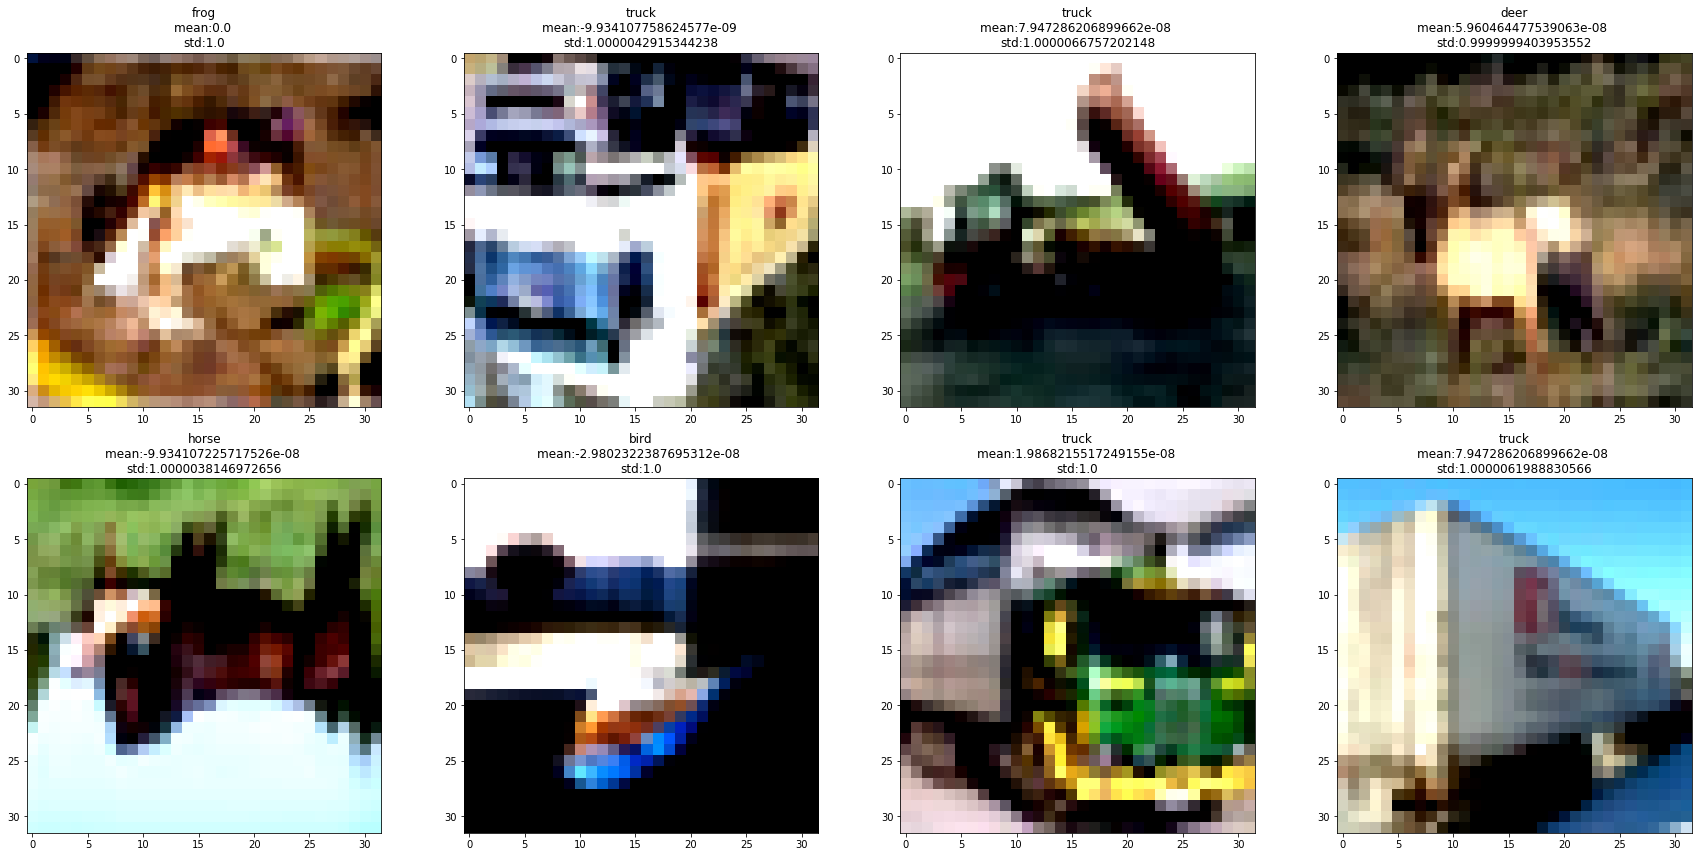

In [169]:
filenames  =get_filenames(data_dir)
#Extract the data from the binary file:
dataset = tf.data.FixedLengthRecordDataset(filenames = filenames,record_bytes=record_bytes)
print(dataset)


num_parallel_calls = None
#Transform:
dataset_parsed = dataset.map(parser)
print(dataset_parsed)

if  mode == 'train':
    '''
    Preprocessin for training data
    '''
    dataset_transformed = dataset_parsed.map(lambda image,label:image_transform(image,label),num_parallel_calls = num_parallel_calls)
    pass
elif mode == 'eval':
    '''
    Preprocessing for validation data
    '''
    pass
elif mode == 'prediction':
    pass


dataset_batched = dataset_transformed.batch(batch_size = batch_size)

dataset_shuffled = dataset_batched.shuffle(buffer_size = 5)

dataset_repeated = dataset_shuffled.repeat(count = epoch)

dataset_prefetched = dataset_repeated.prefetch(buffer_size = batch_size)

iterator = dataset_prefetched.make_one_shot_iterator()

images,labels,images_std = iterator.get_next()

# label_oh = tf.one_hot(label)


start_time =time.time()
step = 1000

plt.figure(figsize=(30,30))
with tf.Session() as sess:
    for i in range(step):
        if i>1:
            images_value,labels_value,images_std_value = sess.run([images,labels,images_std])
            pass
        else:
            images_value,labels_value,images_std_value = sess.run([images,labels,images_std])
            print('images shape:{0}\nlabels shape:{1}'.format(images_value.shape,labels_value.shape))
            for j in range(batch_size):
                plt.subplot(4,4,i*4+j+1)
                plt.imshow(images_value[j])
                mean = np.mean(images_std_value[j])
                std  = np.std(images_std_value[j])
                lable_name = label_dict[labels_value[j][0]]
                plt.title(lable_name+'\nmean:{0} \nstd:{1}'.format(mean,std))
end_time = time.time()
duration = end_time-start_time
print('The duration:{}'.format(duration))